<a href="https://colab.research.google.com/github/prtk0007/Pneumonia-Covid19-detection/blob/main/multiclass_model-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# # !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
#! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip \*.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install split-folders
import splitfolders
splitfolders.ratio("/content/COVID-19 Radiography Database", output="Data", seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 3886 files [00:04, 907.97 files/s] 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
train_path = '/content/drive/MyDrive/Covid git/Data/train'
#test_path = '/content/test'
valid_path = '/content/drive/MyDrive/Covid git/Data/val'

In [ ]:

#Define standard parameter values
batch_size = 32
img_height = 500
img_width = 500


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=20,
                                   horizontal_flip = True,
                              
                               )  

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size
                                      )

# test = test_data_gen.flow_from_directory(
#       test_path,
#       target_size=(img_height, img_width),
#       color_mode='grayscale',shuffle=False,
#       class_mode='binary',
#       batch_size=batch_size
#       )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='categorical', 
      batch_size=batch_size
      )

Found 3108 images belonging to 3 classes.
Found 778 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
# let's build the CNN model

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (1, 1), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (1, 1), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(128, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 256))
cnn.add(Dropout(0.4))

cnn.add(Dense(activation = 'softmax', units = 3))


cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 498, 498, 32)      320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 498, 498, 32)      128       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 123, 123, 32)      1056      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 61, 61, 32)       

In [ ]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=4)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.1, min_lr=0.0001)

callbacks_list = [ early, learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.0791666666666666, 1: 0.9664179104477612, 2: 0.9628252788104089}


In [ ]:
r = cnn.fit(train,epochs=20, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/20
98/98 [==============================] - 100s 1s/step - loss: 0.6335 - accuracy: 0.7135 - val_loss: 1.2485 - val_accuracy: 0.3201
Epoch 2/20
98/98 [==============================] - 98s 1s/step - loss: 0.3284 - accuracy: 0.8756 - val_loss: 1.9007 - val_accuracy: 0.3779
Epoch 3/20
98/98 [==============================] - 98s 999ms/step - loss: 0.2472 - accuracy: 0.9104 - val_loss: 1.8263 - val_accuracy: 0.6041

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/20
98/98 [==============================] - 99s 1s/step - loss: 0.2323 - accuracy: 0.9243 - val_loss: 1.2609 - val_accuracy: 0.6015
Epoch 5/20
98/98 [==============================] - 97s 994ms/step - loss: 0.1829 - accuracy: 0.9354 - val_loss: 0.4706 - val_accuracy: 0.7943
Epoch 6/20
98/98 [==============================] - 97s 986ms/step - loss: 0.2066 - accuracy: 0.9257 - val_loss: 0.2302 - val_accuracy: 0.9229
Epoch 7/20
98/98 [==============================] - 97s 991ms/step -

In [ ]:
cnn.evaluate(train)

98/98 [==============================] - 82s 838ms/step - loss: 0.1337 - accuracy: 0.9540


[0.133663147687912, 0.9539896845817566]

In [ ]:
cnn.evaluate(valid)

25/25 [==============================] - 10s 406ms/step - loss: 0.1457 - accuracy: 0.9512


[0.1457148790359497, 0.9511567950248718]

In [ ]:
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [ ]:
from keras.models import load_model
cnn.save('3_class_scratch_softmax_acc95.h5')


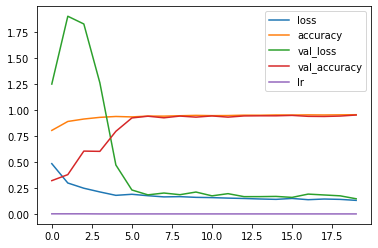

In [ ]:
pd.DataFrame(r.history).plot()

In [ ]:
preds = cnn.predict(valid,verbose=1)

25/25 [==============================] - 10s 409ms/step


In [ ]:
preds

array([[9.9999297e-01, 2.7397400e-07, 6.7899969e-06],
       [9.9949384e-01, 4.0886545e-04, 9.7253964e-05],
       [9.9742824e-01, 2.4014052e-03, 1.7036885e-04],
       ...,
       [9.4917966e-03, 7.0919530e-03, 9.8341620e-01],
       [4.4361273e-05, 5.4860732e-04, 9.9940705e-01],
       [2.7229907e-03, 7.8632766e-01, 2.1094930e-01]], dtype=float32)

In [ ]:
predictions = preds.copy()
predictions = np.argmax(predictions,axis=1)
# predictions[predictions <= 0.5] = 0
# predictions[predictions > 0.5] = 1


In [ ]:
print(train.class_indices)
predictions

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

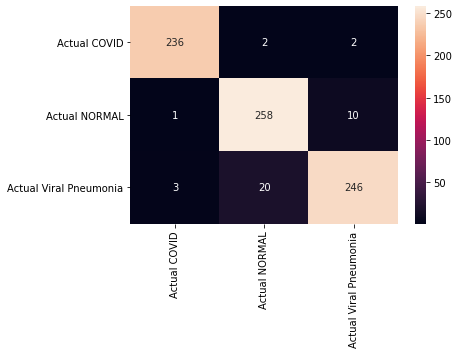

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(valid.classes, predictions, labels=[0, 1, 2]),
                  index=["Actual COVID", "Actual NORMAL", "Actual Viral Pneumonia"],
                  columns=["Actual COVID", "Actual NORMAL", "Actual Viral Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
 print(classification_report(y_true=valid.classes, y_pred=predictions,
                            target_names =['COVID','NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

       COVID       0.98      0.98      0.98       240
      NORMAL       0.92      0.96      0.94       269
   PNEUMONIA       0.95      0.91      0.93       269

    accuracy                           0.95       778
   macro avg       0.95      0.95      0.95       778
weighted avg       0.95      0.95      0.95       778

